In [1]:
!pip install evaluate==0.4.5 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == 

In [2]:
import glob
import os

import evaluate
import kagglehub
import matplotlib.pyplot as plt
import random
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from datasets import Dataset, DatasetDict
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor

2025-10-04 21:42:44.410332: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759614164.775460      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759614164.884958      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
subset_ratio = 1
epochs = 50
batch_size = 16

random_imgs = []
if subset_ratio == 1:
    random_imgs = [26, 662, 834, 442, 1493]
elif subset_ratio >= 0.1:
    random_imgs = [3, 12, 16, 24, 26]
else:
    raise Exception(f"Unsupported subset_ratio: {subset_ratio}")

init_evals = True

In [4]:
seed = 42

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

g = torch.Generator()
g.manual_seed(seed)

In [5]:
model_id = "nvidia/segformer-b0-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained(model_id)
processor = SegformerImageProcessor.from_pretrained(model_id)

metric = evaluate.load("mean_iou")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/15.0M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerImageProcessor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


cuda


In [6]:
ade20k_path = kagglehub.dataset_download("awsaf49/ade20k-dataset")
ade20k_path = os.path.join(ade20k_path, "ADEChallengeData2016")

train_images = sorted(glob.glob(os.path.join(ade20k_path, "images", "training", "*.jpg")))
train_masks  = sorted(glob.glob(os.path.join(ade20k_path, "annotations", "training", "*.png")))

val_images = sorted(glob.glob(os.path.join(ade20k_path, "images", "validation", "*.jpg")))
val_masks  = sorted(glob.glob(os.path.join(ade20k_path, "annotations", "validation", "*.png")))

n_train = int(len(train_images) * subset_ratio)
n_val   = int(len(val_images) * subset_ratio)

class SegmentationDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, mask_paths, processor):
        assert len(image_paths) == len(mask_paths), "Mismatch between images and masks"
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if isinstance(idx, list):
            return [self.__getitem__(i) for i in idx]

        img = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx])

        encoding = self.processor(
            images=img,
            segmentation_maps=mask,
            return_tensors="pt"
        )

        pixel_values = encoding["pixel_values"].squeeze(0)
        labels = encoding["labels"].squeeze(0)

        return {"pixel_values": pixel_values, "labels": labels}

train_dataset_small = SegmentationDataset(train_images[:n_train], train_masks[:n_train], processor)
val_dataset_small   = SegmentationDataset(val_images[:n_val], val_masks[:n_val], processor)

train_loader = DataLoader(
    train_dataset_small,
    batch_size=batch_size,
    shuffle=True,
    generator=g,
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset_small,
    batch_size=batch_size,
    shuffle=False,
    generator=g,
    num_workers=4,
    pin_memory=True
)

In [7]:
init_result = 0
if init_evals:
    def evaluate_iou_hf(model, dataloader, num_classes=150, ignore_index=255, device="cuda"):
        model.eval()

        with torch.no_grad():
            for batch in tqdm(dataloader, desc="Evaluating IoU"):
                pixel_values = batch["pixel_values"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)

                if preds.shape[-2:] != labels.shape[-2:]:
                    preds = F.interpolate(
                        preds.unsqueeze(1).float(),
                        size=labels.shape[-2:],
                        mode="nearest"
                    ).squeeze(1).long()

                metric.add_batch(predictions=preds.cpu().numpy(),
                                references=labels.cpu().numpy())

        result = metric.compute(num_labels=num_classes, ignore_index=ignore_index,
                                reduce_labels=False)
        return result


    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    result = evaluate_iou_hf(
        model, val_loader, num_classes=150, ignore_index=255, device=device)
    print(f"Validation Mean IoU: {result['mean_iou']:.4f}")
    init_result = result['mean_iou']
else:
    print("Skipping initial evaluation...")
    print(f"Validation Mean IoU: 0.4834")

Evaluating IoU:   0%|          | 0/125 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:347: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Evaluating IoU: 100%|██████████| 125/125 [00:52<00:00,  2.40it/s]


Validation Mean IoU: 0.3604


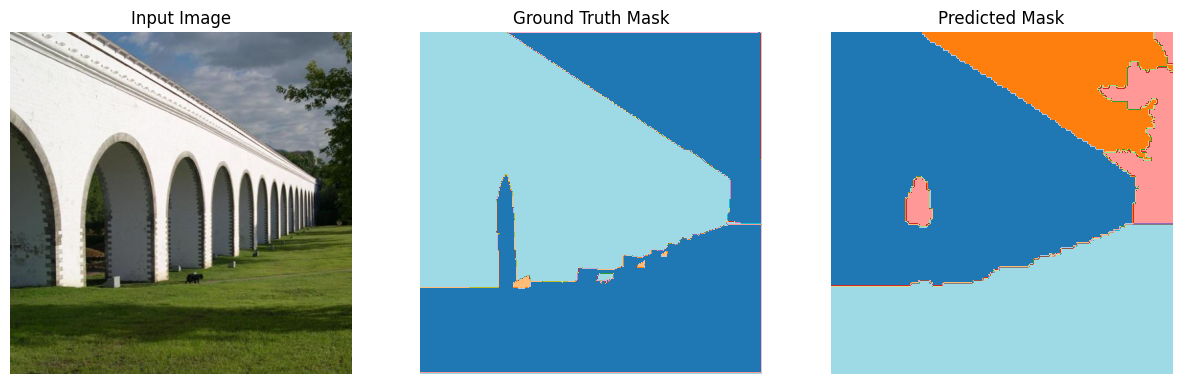

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Mean IoU: 0.5482


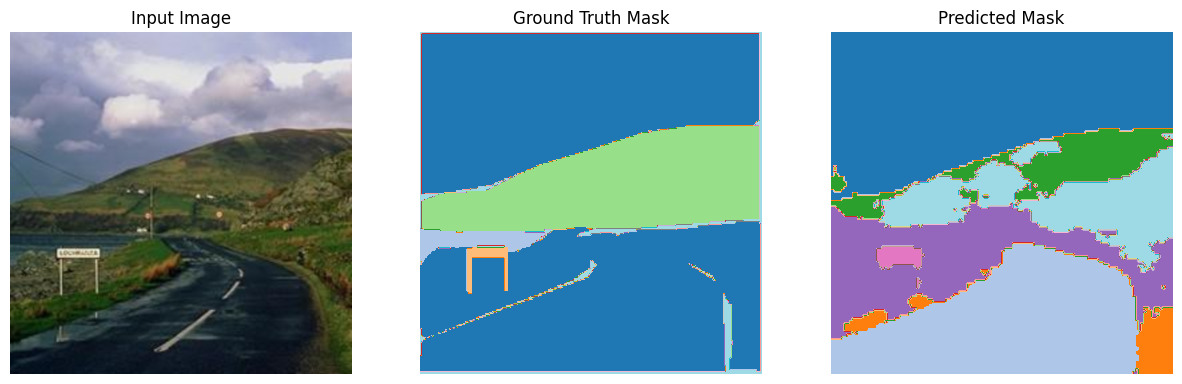

Mean IoU: 0.2984


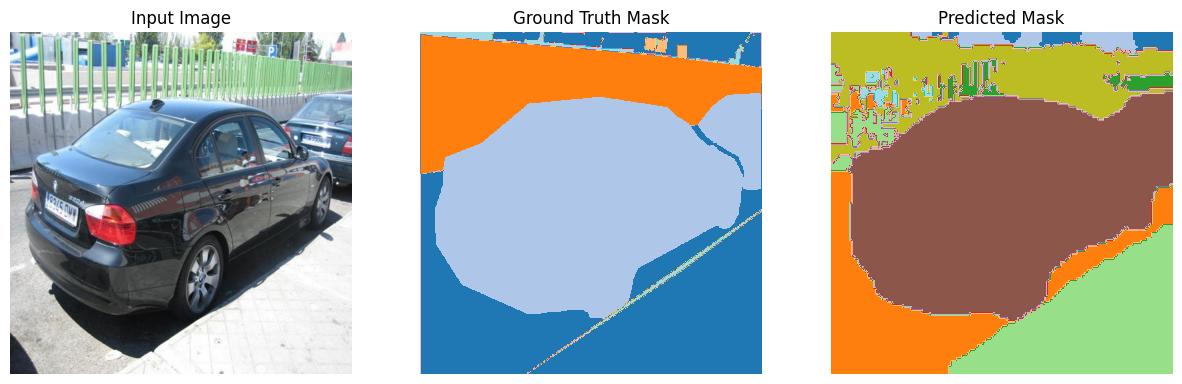

Mean IoU: 0.4152


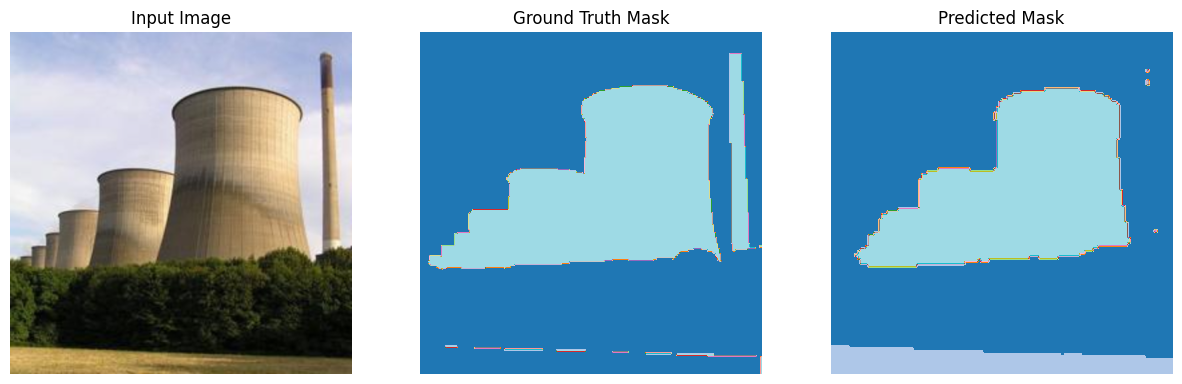

Mean IoU: 0.3639


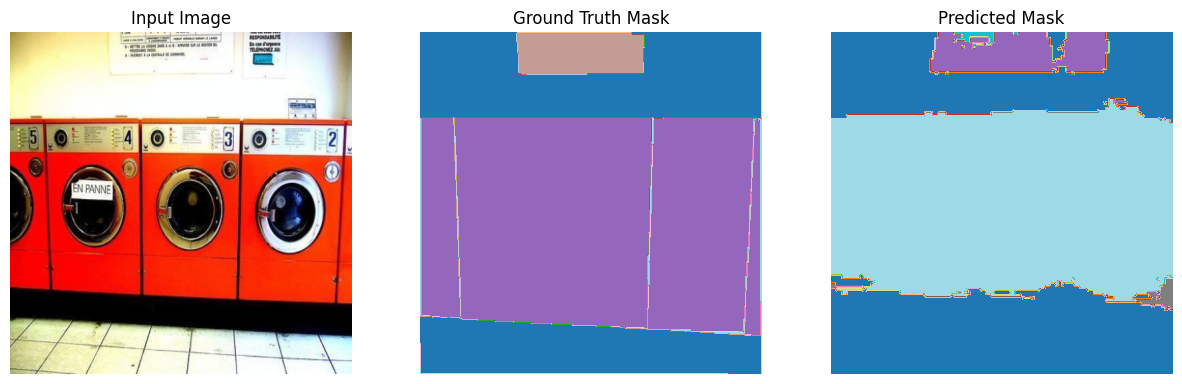

Mean IoU: 0.3200


In [8]:
results = {}
results[0] = [init_result]

for img in random_imgs:
    sample = val_dataset_small[img]
    
    pixel_values = sample["pixel_values"].unsqueeze(0).to(device)
    labels = sample["labels"].unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        outputs = model(pixel_values=pixel_values)
        logits = outputs.logits
        predicted = torch.argmax(logits, dim=1) 
    
    pred_mask = predicted.squeeze().cpu().numpy()
    true_mask = labels.squeeze().cpu().numpy()
    
    image_np = pixel_values.squeeze().permute(1, 2, 0).cpu().numpy()
    image_np = (image_np * processor.image_std + processor.image_mean).clip(0, 1)
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(image_np)
    axes[0].set_title("Input Image")
    axes[0].axis("off")
    
    axes[1].imshow(true_mask, cmap="tab20")
    axes[1].set_title("Ground Truth Mask")
    axes[1].axis("off")
    
    axes[2].imshow(pred_mask, cmap="tab20")
    axes[2].set_title("Predicted Mask")
    axes[2].axis("off")
    
    plt.show()
    
    def calculate_iou(true_mask, pred_mask, num_classes=150, ignore_index=255):
        if true_mask.shape != pred_mask.shape:
            true_mask_resized = np.array(
                Image.fromarray(true_mask.astype(np.uint8)).resize(
                    (pred_mask.shape[1], pred_mask.shape[0]),
                    resample=Image.NEAREST
                )
            )
        else:
            true_mask_resized = true_mask
    
        results = metric.compute(
            predictions=[pred_mask],
            references=[true_mask_resized],
            num_labels=num_classes,
            ignore_index=ignore_index,
            reduce_labels=False
        )
    
        mean_iou = results["mean_iou"]
        per_class_iou = results.get("iou", {})
        return mean_iou, per_class_iou
    
    mean_iou, per_class_iou = calculate_iou(true_mask, pred_mask)
    print(f"Mean IoU: {mean_iou:.4f}")

    results[img] = [mean_iou]

In [9]:
def evaluate_iou(model, dataloader, num_classes=150, ignore_index=None, device="cuda"):
    model.to(device)
    model.eval()

    metric = evaluate.load("mean_iou")

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            preds = preds.cpu().numpy()
            labels = labels.cpu().numpy()

            for p, l in zip(preds, labels):
                if p.shape != l.shape:
                    p = np.array(
                        Image.fromarray(p.astype(np.uint8)).resize(
                            (l.shape[1], l.shape[0]), 
                            resample=Image.NEAREST
                        )
                    )
                all_preds.append(p)
                all_labels.append(l)

    results = metric.compute(
        predictions=all_preds,
        references=all_labels,
        num_labels=num_classes,
        ignore_index=ignore_index,
        reduce_labels=False 
    )

    return results["mean_iou"]

Using device: cuda

Starting training...

[Epoch 1] Validation Mean IoU: 0.2907
[Epoch 2] Validation Mean IoU: 0.2937
[Epoch 3] Validation Mean IoU: 0.2951
[Epoch 4] Validation Mean IoU: 0.2945
[Epoch 5] Validation Mean IoU: 0.2949
[Epoch 6] Validation Mean IoU: 0.2953
[Epoch 7] Validation Mean IoU: 0.2962
[Epoch 8] Validation Mean IoU: 0.2958
[Epoch 9] Validation Mean IoU: 0.2969


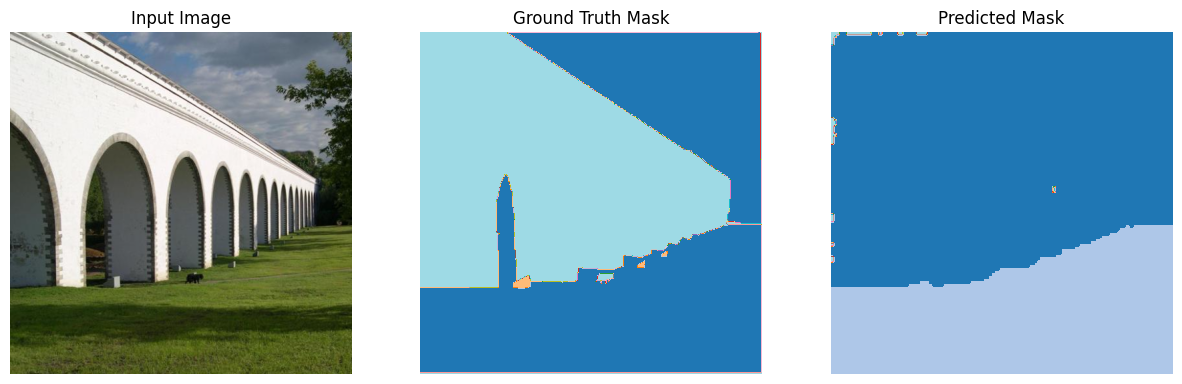

[Epoch 10] Mean IoU: 0.4558


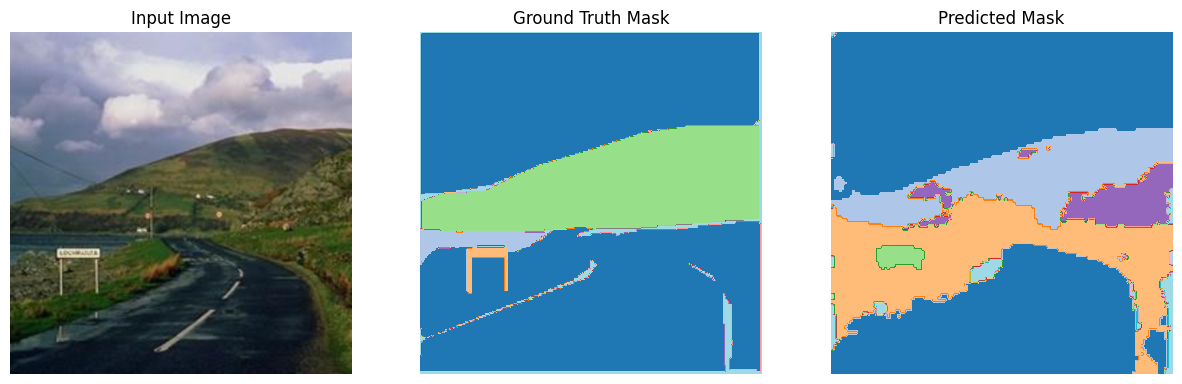

[Epoch 10] Mean IoU: 0.2635


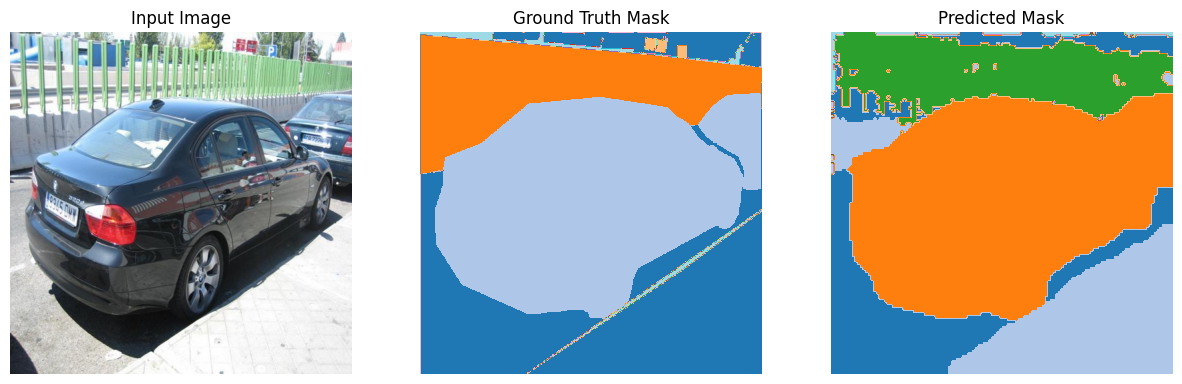

[Epoch 10] Mean IoU: 0.3695


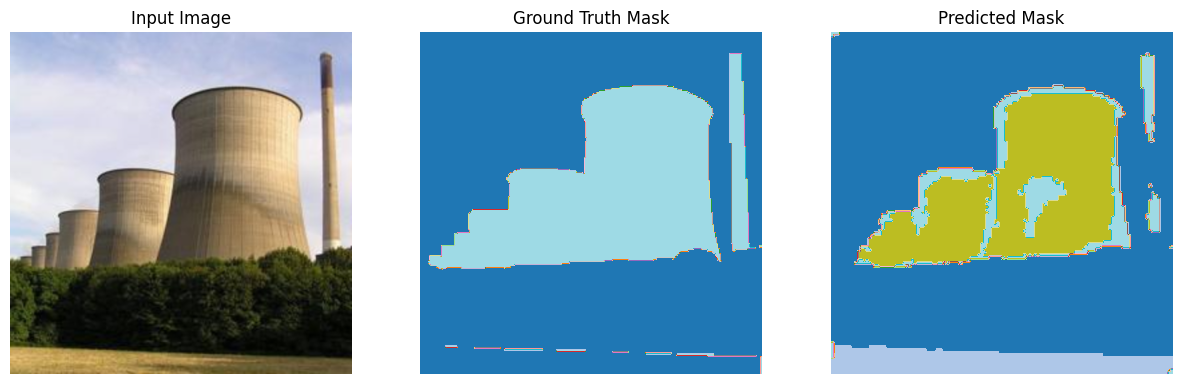

[Epoch 10] Mean IoU: 0.4053


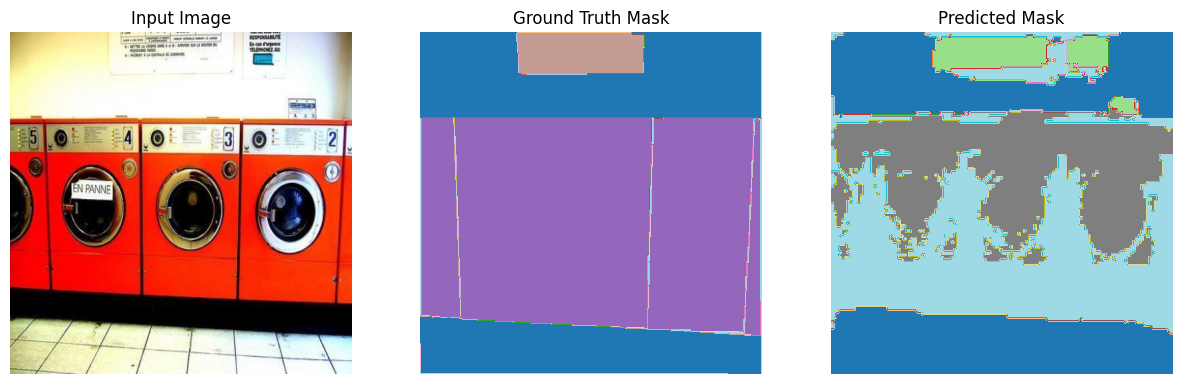

[Epoch 10] Mean IoU: 0.3435
[Epoch 10] Validation Mean IoU: 0.2964
[Epoch 11] Validation Mean IoU: 0.2967
[Epoch 12] Validation Mean IoU: 0.2977
[Epoch 13] Validation Mean IoU: 0.2992
[Epoch 14] Validation Mean IoU: 0.2979
[Epoch 15] Validation Mean IoU: 0.2969
[Epoch 16] Validation Mean IoU: 0.2980
[Epoch 17] Validation Mean IoU: 0.2989
[Epoch 18] Validation Mean IoU: 0.2973
[Epoch 19] Validation Mean IoU: 0.2984


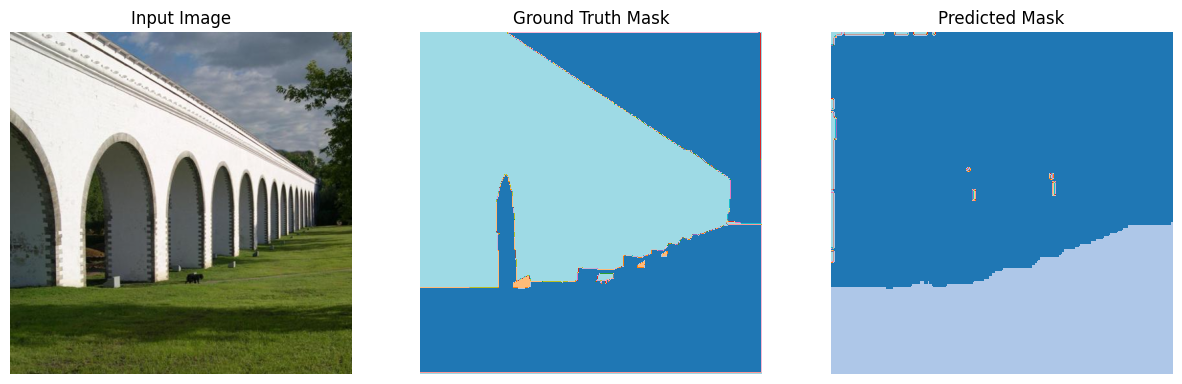

[Epoch 20] Mean IoU: 0.4573


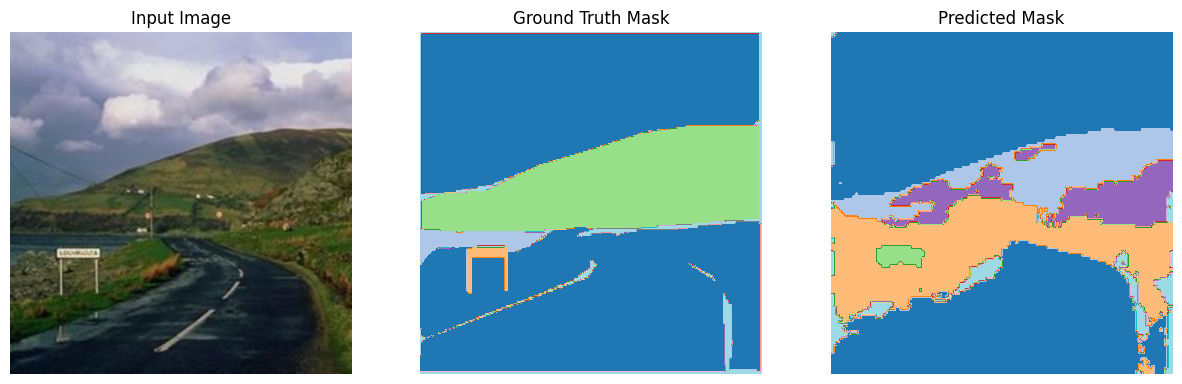

[Epoch 20] Mean IoU: 0.3066


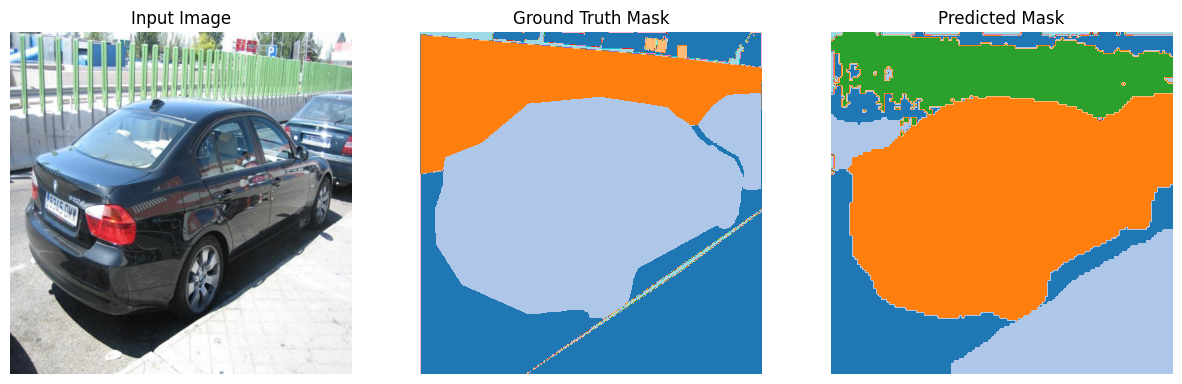

[Epoch 20] Mean IoU: 0.3652


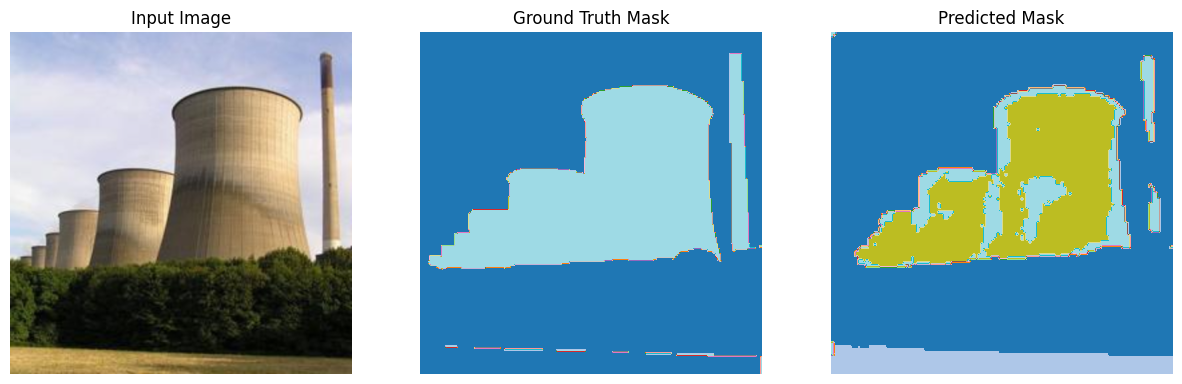

[Epoch 20] Mean IoU: 0.4020


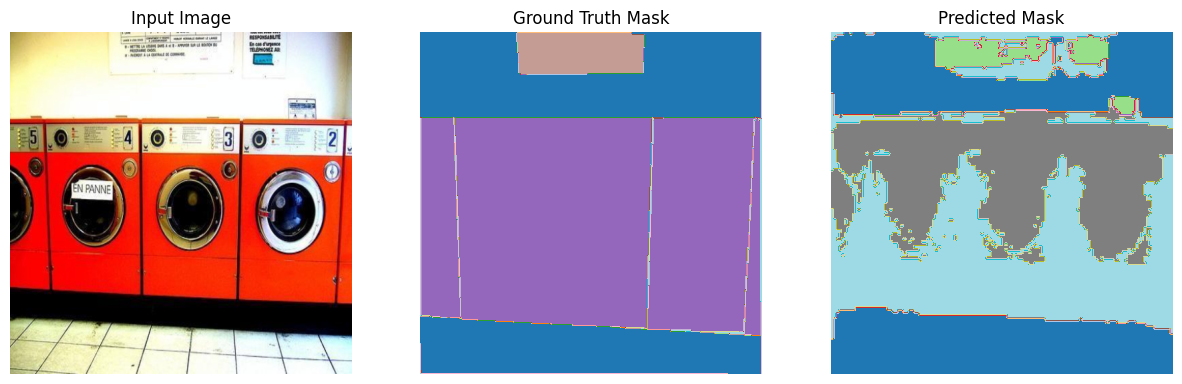

[Epoch 20] Mean IoU: 0.3473
[Epoch 20] Validation Mean IoU: 0.2987
[Epoch 21] Validation Mean IoU: 0.2977
[Epoch 22] Validation Mean IoU: 0.2982
[Epoch 23] Validation Mean IoU: 0.2971
[Epoch 24] Validation Mean IoU: 0.2989
[Epoch 25] Validation Mean IoU: 0.2993
[Epoch 26] Validation Mean IoU: 0.2983
[Epoch 27] Validation Mean IoU: 0.2987
[Epoch 28] Validation Mean IoU: 0.2982
[Epoch 29] Validation Mean IoU: 0.2982


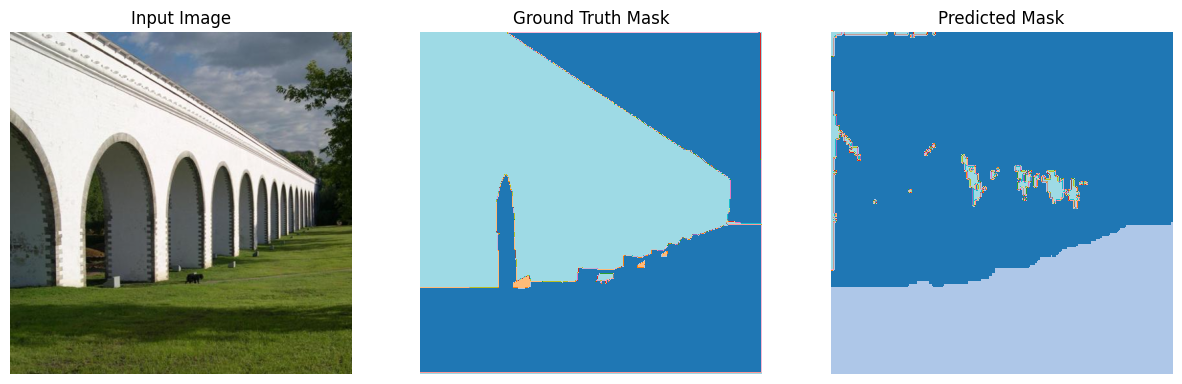

[Epoch 30] Mean IoU: 0.4590


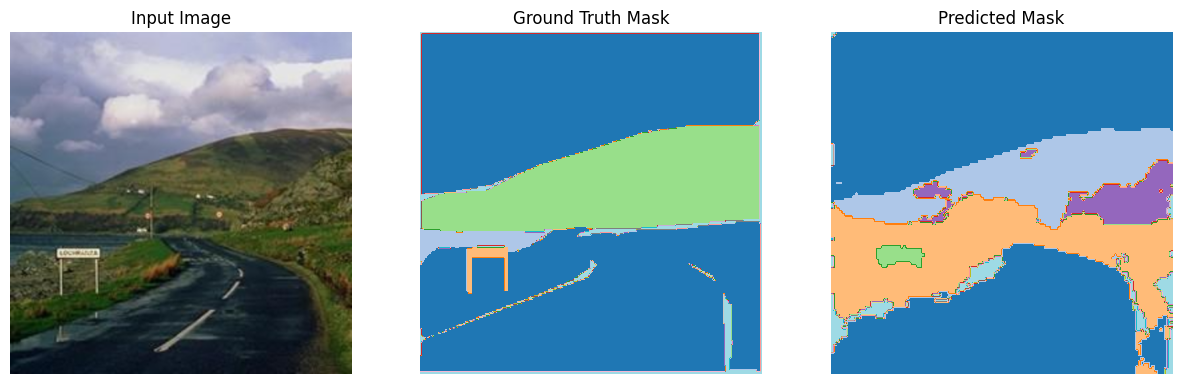

[Epoch 30] Mean IoU: 0.2628


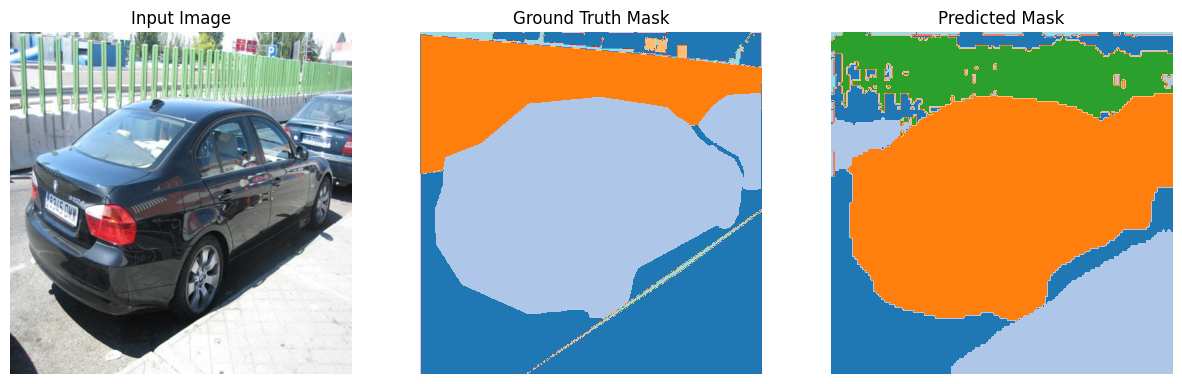

[Epoch 30] Mean IoU: 0.3715


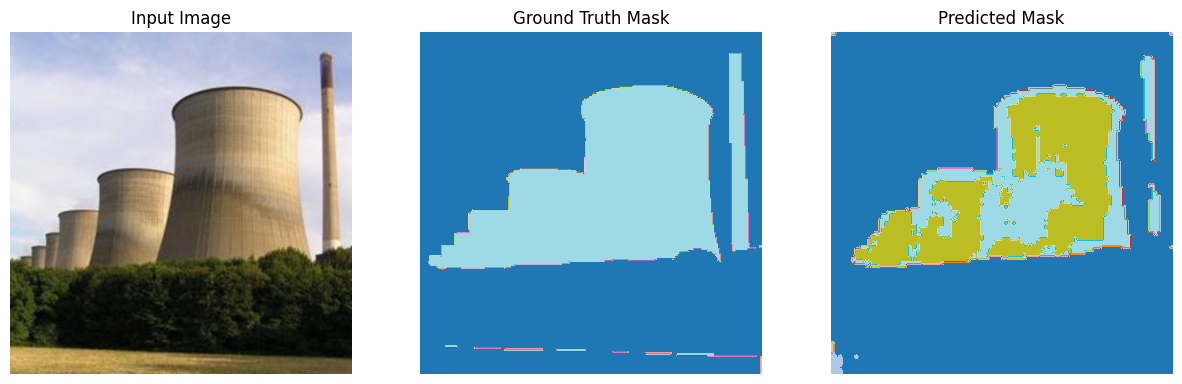

[Epoch 30] Mean IoU: 0.4019


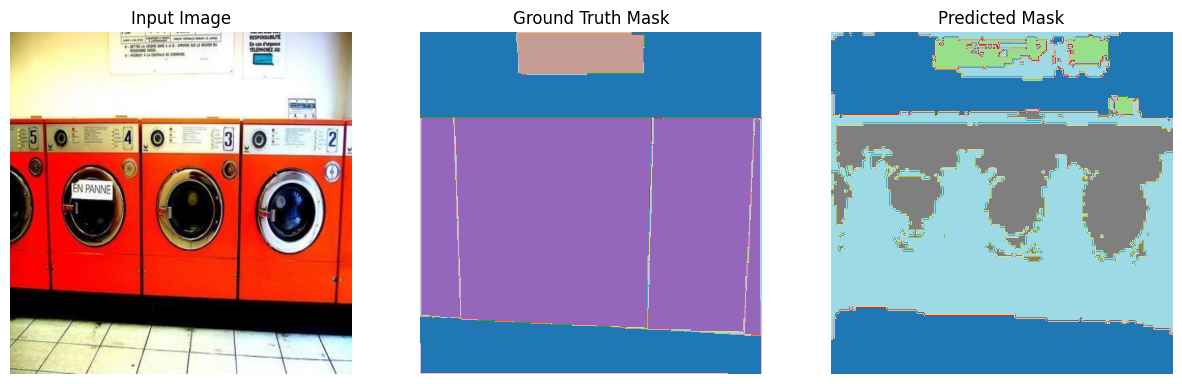

[Epoch 30] Mean IoU: 0.3339
[Epoch 30] Validation Mean IoU: 0.3004
[Epoch 31] Validation Mean IoU: 0.2995
[Epoch 32] Validation Mean IoU: 0.2997
[Epoch 33] Validation Mean IoU: 0.2996
[Epoch 34] Validation Mean IoU: 0.2995
[Epoch 35] Validation Mean IoU: 0.3006
[Epoch 36] Validation Mean IoU: 0.3003
[Epoch 37] Validation Mean IoU: 0.3009
[Epoch 38] Validation Mean IoU: 0.3006
[Epoch 39] Validation Mean IoU: 0.3027


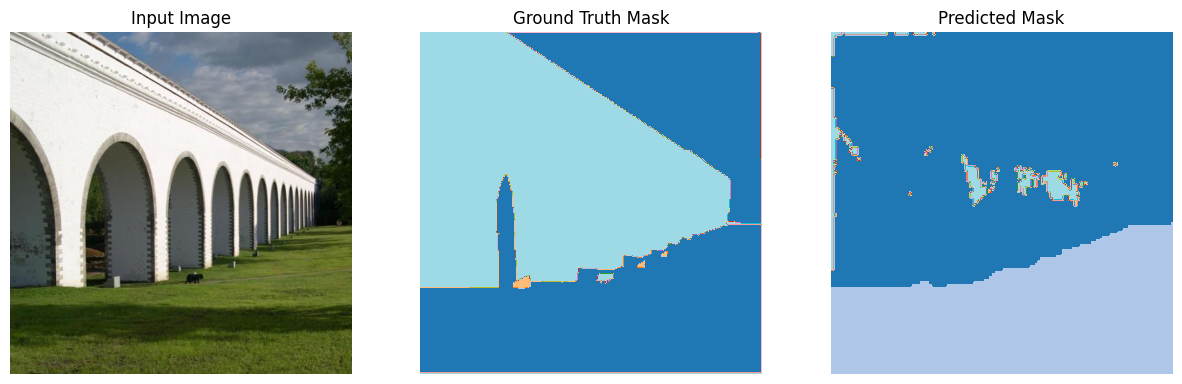

[Epoch 40] Mean IoU: 0.4578


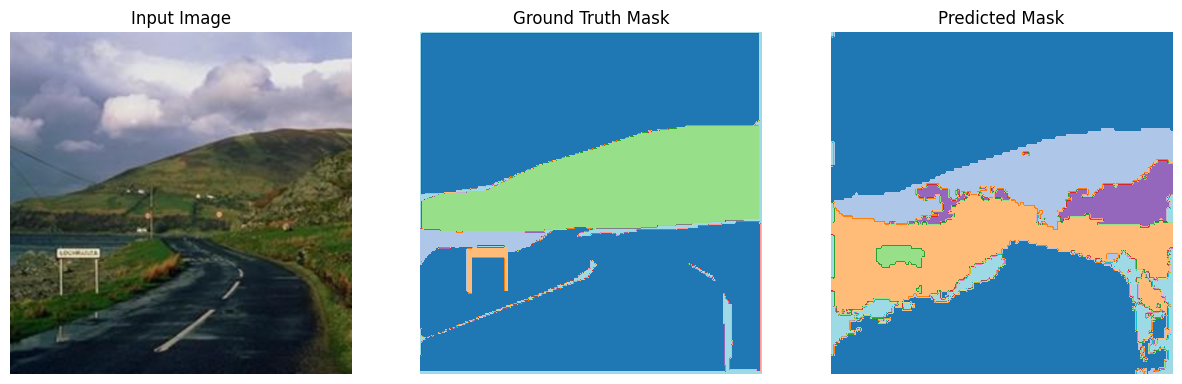

[Epoch 40] Mean IoU: 0.2650


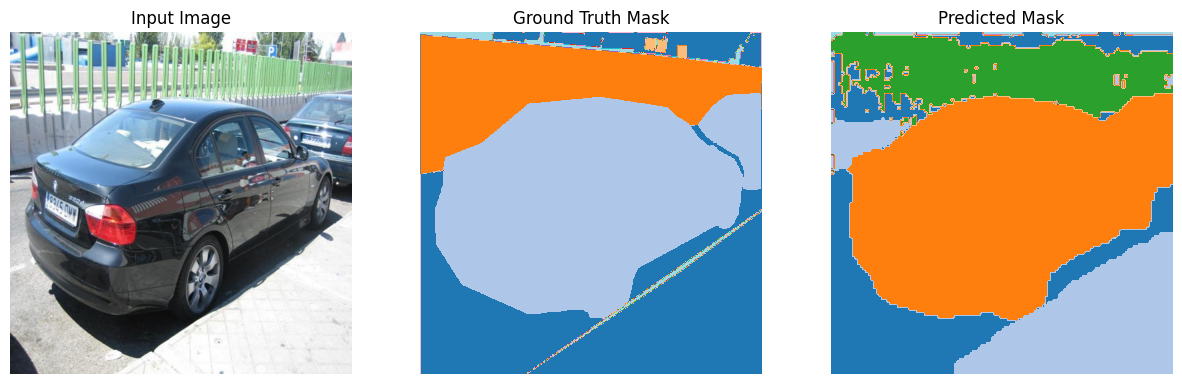

[Epoch 40] Mean IoU: 0.3606


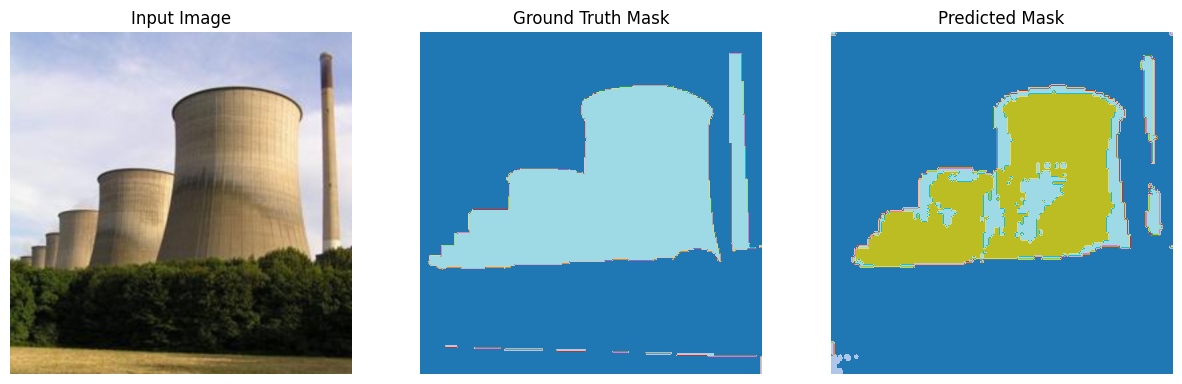

[Epoch 40] Mean IoU: 0.4014


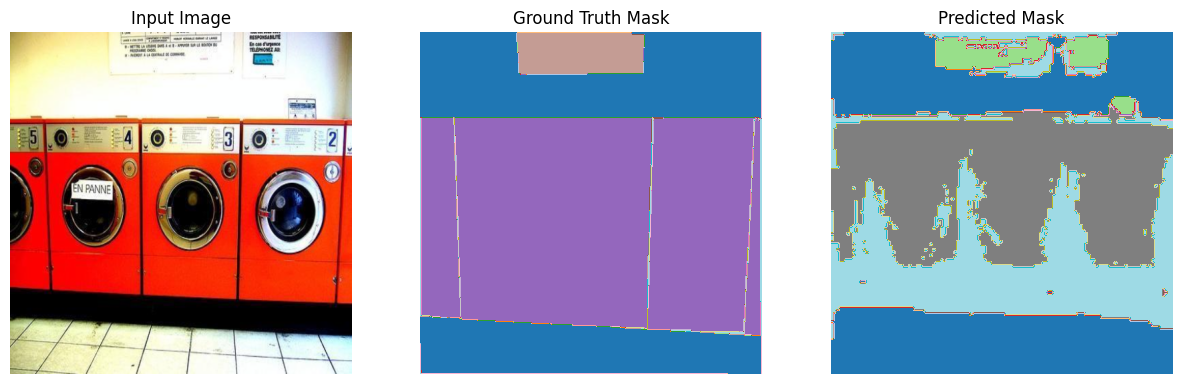

[Epoch 40] Mean IoU: 0.3098
[Epoch 40] Validation Mean IoU: 0.3019
[Epoch 41] Validation Mean IoU: 0.2997
[Epoch 42] Validation Mean IoU: 0.3006
[Epoch 43] Validation Mean IoU: 0.3018
[Epoch 44] Validation Mean IoU: 0.3017
[Epoch 45] Validation Mean IoU: 0.3021
[Epoch 46] Validation Mean IoU: 0.2988
[Epoch 47] Validation Mean IoU: 0.3015
[Epoch 48] Validation Mean IoU: 0.2997
[Epoch 49] Validation Mean IoU: 0.3003


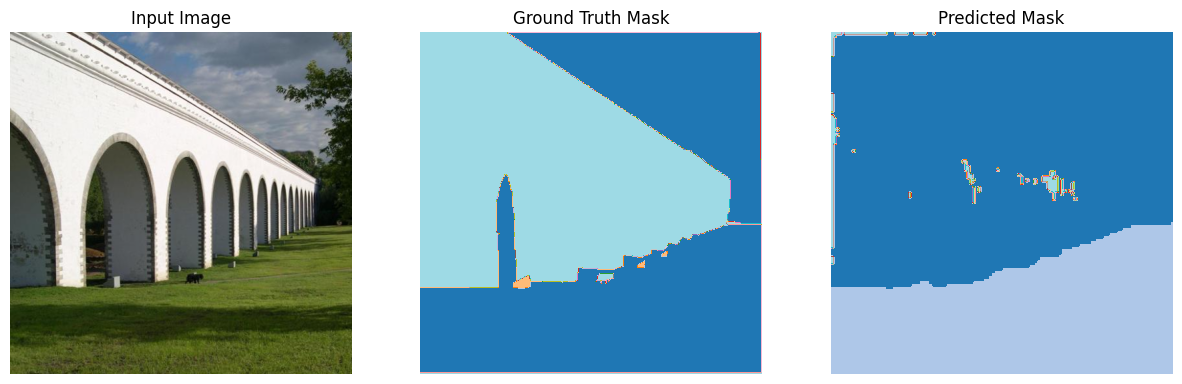

[Epoch 50] Mean IoU: 0.4575


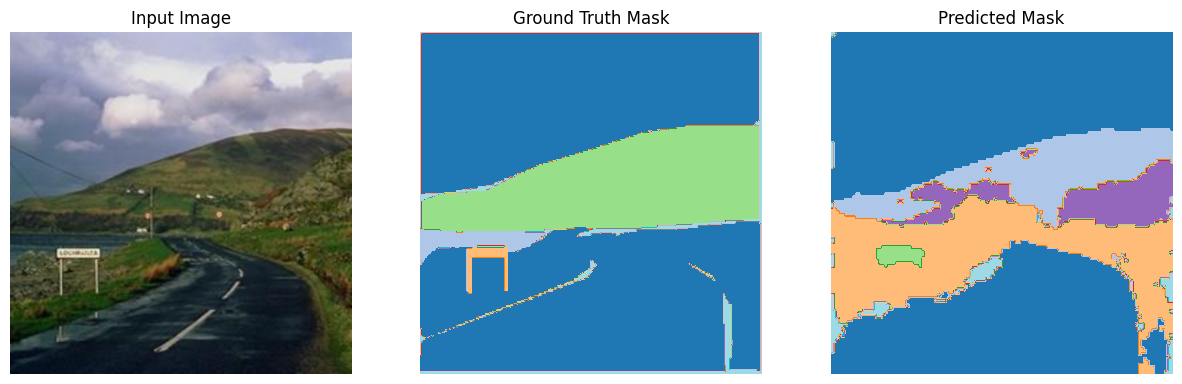

[Epoch 50] Mean IoU: 0.2486


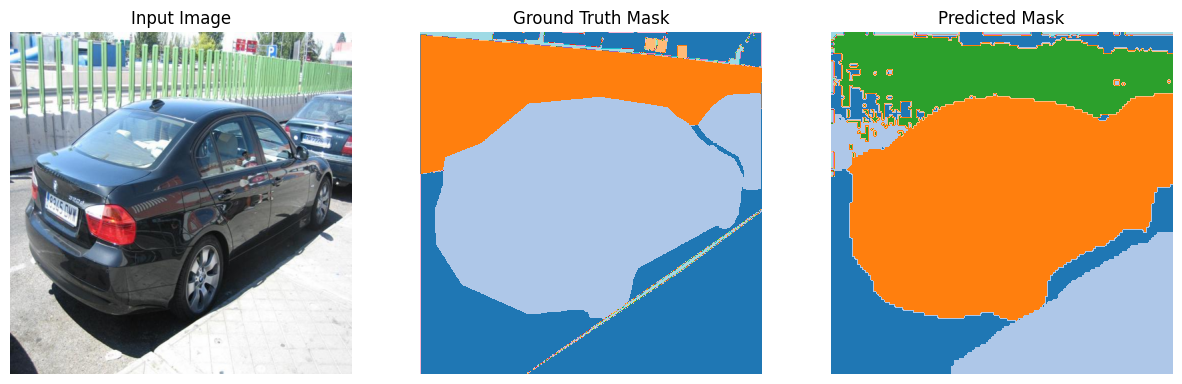

[Epoch 50] Mean IoU: 0.3592


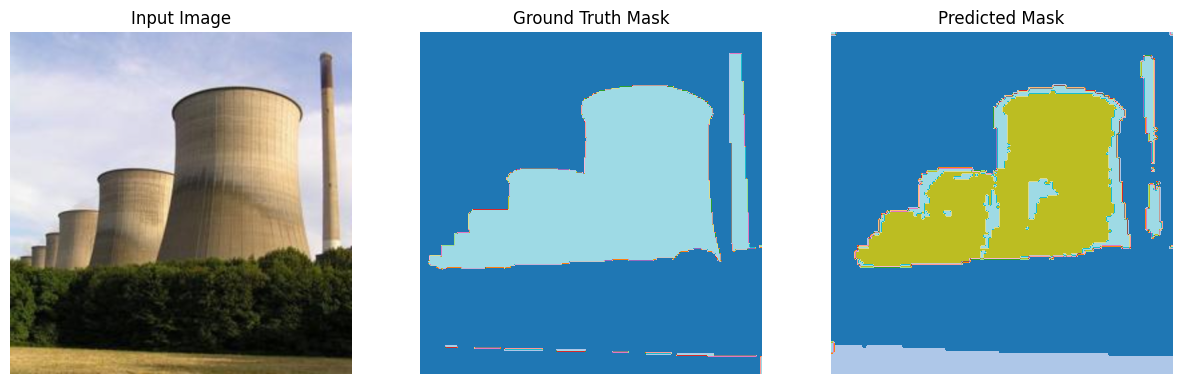

[Epoch 50] Mean IoU: 0.3991


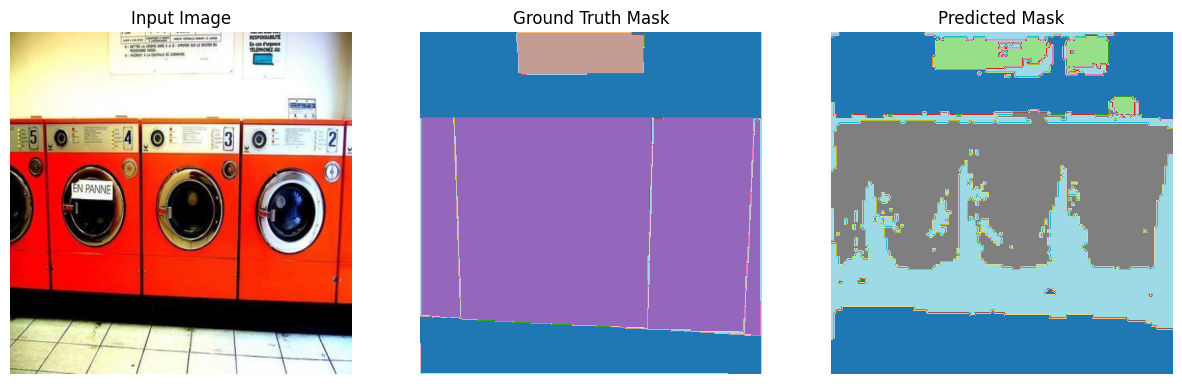

[Epoch 50] Mean IoU: 0.3684
[Epoch 50] Validation Mean IoU: 0.3013


In [10]:
model_id = "nvidia/segformer-b0-finetuned-ade-512-512"
model = SegformerForSemanticSegmentation.from_pretrained(model_id)
processor = SegformerImageProcessor.from_pretrained(model_id)

metric = evaluate.load("mean_iou")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

class CustomSegformerDecodeHead(nn.Module):
    def __init__(self, original_head):
        super().__init__()
        self.linear_c = nn.ModuleList(original_head.linear_c)
        self.linear_fuse = original_head.linear_fuse
        self.batch_norm = original_head.batch_norm
        self.activation = original_head.activation
        self.dropout = original_head.dropout
        self.classifier = original_head.classifier

        # Squeeze-and-Excitation block (channel attention)
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(256, 256 // 16, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256 // 16, 256, 1),
            nn.Sigmoid()
        )

    def forward(self, inputs):
        mlp_outputs = []
        target_size = inputs[0].shape[-2:]
        for i, (x, mlp) in enumerate(zip(inputs, self.linear_c)):
            x = mlp(x)
            bs, L, C = x.shape
            H, W = inputs[i].shape[2], inputs[i].shape[3]
            x = x.transpose(1, 2).reshape(bs, C, H, W)

            if x.shape[2:] != target_size:
                x = F.interpolate(x, size=target_size, mode="bilinear", align_corners=False)
            
            mlp_outputs.append(x)

        x = torch.cat(mlp_outputs[::-1], dim=1)

        x = self.linear_fuse(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        
        # Channel attention via SE
        scale = self.se(x)
        x = x * scale

        x = self.dropout(x)
        x = self.classifier(x)
        return x
    
model.decode_head = CustomSegformerDecodeHead(model.decode_head)

for name, param in model.named_parameters():
    param.requires_grad = False

for name, param in model.decode_head.linear_fuse.named_parameters():
    param.requires_grad = True

for name, param in model.decode_head.se.named_parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=150)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

print("\nStarting training...\n")

model.train()
for epoch in range(epochs):
    for batch_idx, batch in enumerate(train_loader):
        inputs, labels = batch["pixel_values"].to(device), batch["labels"].to(device)

        optimizer.zero_grad()

        outputs = model(pixel_values=inputs).logits

        labels_resized = F.interpolate(
            labels.unsqueeze(1).float(),
            size=outputs.shape[2:],
            mode="nearest"
        ).squeeze(1).long()
        labels_resized = torch.clamp(labels_resized, max=149)

        loss = criterion(outputs, labels_resized)
        loss.backward()
        optimizer.step()

    model.eval()

    if (epoch + 1) % 10 == 0:
        for img in random_imgs:
            with torch.no_grad():
                sample = val_dataset_small[img]
        
                pixel_values = sample["pixel_values"].unsqueeze(0).to(device)
                labels = sample["labels"].unsqueeze(0).to(device)
        
                outputs = model(pixel_values=pixel_values)
                logits = outputs.logits
                predicted = torch.argmax(logits, dim=1)
        
                pred_mask = predicted.squeeze().cpu().numpy()
                true_mask = labels.squeeze().cpu().numpy()
        
                image_np = pixel_values.squeeze().permute(1, 2, 0).cpu().numpy()
                image_np = (image_np * processor.image_std + processor.image_mean).clip(0, 1)
        
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
                axes[0].imshow(image_np)
                axes[0].set_title("Input Image")
                axes[0].axis("off")
        
                axes[1].imshow(true_mask, cmap="tab20")
                axes[1].set_title("Ground Truth Mask")
                axes[1].axis("off")
        
                axes[2].imshow(pred_mask, cmap="tab20")
                axes[2].set_title("Predicted Mask")
                axes[2].axis("off")
        
                plt.show()
        
                mean_iou, per_class_iou = calculate_iou(true_mask, pred_mask)
                print(f"[Epoch {epoch+1}] Mean IoU: {mean_iou:.4f}")
    
                results[img].append(mean_iou)


    total_iou = 0.0
    num_samples = 0

    with torch.no_grad():
        for val_batch in val_loader:
            val_inputs = val_batch["pixel_values"].to(device)
            val_labels = val_batch["labels"].to(device)

            outputs = model(pixel_values=val_inputs).logits
            preds = torch.argmax(outputs, dim=1)

            if val_labels.shape[1:] != preds.shape[1:]:
                val_labels_resized = F.interpolate(
                    val_labels.unsqueeze(1).float(),
                    size=outputs.shape[2:],
                    mode="nearest"
                ).squeeze(1).long()
            else:
                val_labels_resized = val_labels

            val_labels_resized = torch.clamp(val_labels_resized, max=149)

            batch_iou = 0.0
            for gt, pred in zip(val_labels_resized.cpu().numpy(), preds.cpu().numpy()):
                miou, _ = calculate_iou(gt, pred)
                batch_iou += miou
            batch_mean_iou = batch_iou / val_inputs.size(0)

            total_iou += batch_mean_iou * val_inputs.size(0)
            num_samples += val_inputs.size(0)

    epoch_iou = total_iou / num_samples
    print(f"[Epoch {epoch+1}] Validation Mean IoU: {epoch_iou:.4f}")
    results[0].append(epoch_iou)

    model.train()

In [11]:
print(results)

{0: [0.36042406022571544, 0.2906597270963071, 0.2936977484650385, 0.2950884543779974, 0.2944933454417751, 0.29490879543135484, 0.2952736205335242, 0.2962499467581113, 0.2958420932677367, 0.29688423092388705, 0.2964361733293772, 0.2967150564413894, 0.2976683369477496, 0.2992019643180834, 0.2978793234262427, 0.29687424147367514, 0.29799596322600064, 0.2988605826955526, 0.2973089957286832, 0.2984448362058647, 0.29870819942623555, 0.2977040947117858, 0.29820604552633045, 0.2970673588402719, 0.29889254032410245, 0.29927392665333535, 0.29826996259999533, 0.29872486662223463, 0.2982246778532281, 0.29815861638888935, 0.30038122319512894, 0.299509862279857, 0.29972041874540717, 0.29959081521392306, 0.2994537324894665, 0.3006192619193725, 0.30034601475372735, 0.3009426889730093, 0.3006140018935782, 0.3026770411899844, 0.3018634506259241, 0.2997379501269037, 0.3006414633717971, 0.3018024585780671, 0.3016983303221311, 0.3021310976069956, 0.2987759189132819, 0.3015178626116734, 0.29965045076490193,

In [12]:
for img_idx, iou_values in results.items():
    if not isinstance(iou_values, list):
        iou_values = [iou_values]
    
    formatted_values = ", ".join(f"{v:.4f}" for v in iou_values)
    print(f"Image {img_idx}: {formatted_values}")

Image 0: 0.3604, 0.2907, 0.2937, 0.2951, 0.2945, 0.2949, 0.2953, 0.2962, 0.2958, 0.2969, 0.2964, 0.2967, 0.2977, 0.2992, 0.2979, 0.2969, 0.2980, 0.2989, 0.2973, 0.2984, 0.2987, 0.2977, 0.2982, 0.2971, 0.2989, 0.2993, 0.2983, 0.2987, 0.2982, 0.2982, 0.3004, 0.2995, 0.2997, 0.2996, 0.2995, 0.3006, 0.3003, 0.3009, 0.3006, 0.3027, 0.3019, 0.2997, 0.3006, 0.3018, 0.3017, 0.3021, 0.2988, 0.3015, 0.2997, 0.3003, 0.3013
Image 26: 0.5482, 0.4558, 0.4573, 0.4590, 0.4578, 0.4575
Image 662: 0.2984, 0.2635, 0.3066, 0.2628, 0.2650, 0.2486
Image 834: 0.4152, 0.3695, 0.3652, 0.3715, 0.3606, 0.3592
Image 442: 0.3639, 0.4053, 0.4020, 0.4019, 0.4014, 0.3991
Image 1493: 0.3200, 0.3435, 0.3473, 0.3339, 0.3098, 0.3684
